In [1]:
# import libraries
import numpy as np
import pandas as pd
import datasets 
from datasets import Features, Image, load_dataset, load_dataset_builder, config, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os

import shutil
import pathlib
import PIL
from PIL import Image
import requests
from io import BytesIO
import wikipedia

import torch
import torchvision
from torchvision.transforms import v2, ToTensor, Lambda
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

Matplotlib created a temporary cache directory at /tmp/matplotlib-lhxd93b0 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# check for GPU and create the device object
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## Data Load and Processing

In [3]:
# get data (from https://huggingface.co/datasets/YakupAkdin/instrument-images/tree/main)
dataset = load_dataset("YakupAkdin/instrument-images", split='train').with_format('torch', device=device)

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
# define our labels
label_values = {
    0: 'harp',
    1: 'baglama',
    2: 'electric guitar',
    3: 'acoustic guitar',
    4: 'kanun',
    5: 'violin',
    6: 'kemence',
    7: 'mandolin',
    8: 'oud',
    9: 'yayli tambur'}

inverted_labels = {v: k for k, v in label_values.items()}

In [5]:
# create a pandas copy for easier PIL
df_clone = dataset.to_pandas()
df_clone = df_clone.assign(
    desc = df_clone.label.map(label_values),
    image = df_clone.image.apply(lambda x: x['path']))
df_clone.head()

,image,label,desc
0,/workspace/hf_cache/downloads/c1788b27609c6ad9...,0,harp
1,/workspace/hf_cache/downloads/8f8cdb21c6698ee6...,0,harp
2,/workspace/hf_cache/downloads/41f7f4b3f28c4ede...,0,harp
3,/workspace/hf_cache/downloads/4bce77de0a7870be...,0,harp
4,/workspace/hf_cache/downloads/e5502c68bcbbc862...,0,harp



 0 : harp


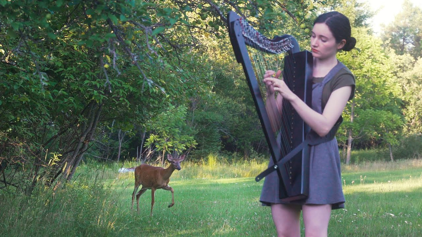


 3 : acoustic guitar


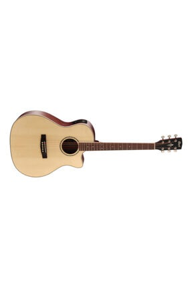


 6 : kemence


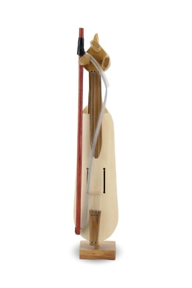


 9 : yayli tambur


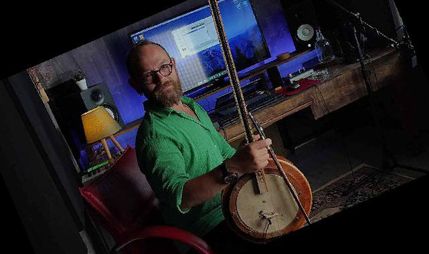

In [6]:
# view some images and labels
def img_check(i, scale):
    print('\n', df_clone.label[i],':',df_clone.desc[i])
    img = PIL.Image.open(df_clone.image[i])
    img = img.resize((int(img.size[0]/(100/scale)), int(img.size[1]/(100/scale))))
    img.show()

img_check(0, 33)
img_check(333, 67)
img_check(666, 67)
img_check(999, 67)

#### Tensor manipulation for mixed image types

In [7]:
# isolate RGB images for pre processing
dataset_RGB = dataset.filter(lambda x: x['image'].dim() == 3)
len(dataset_RGB)

989

In [8]:
# the RGB images are [H,W,3] and PyTorch needs them as [3,H,W]
# included [:3, :, :] slice to adjust any RGBA images to RGB
print(dataset_RGB[0]['image'].shape)

# permute the tensors
def permute_images(batch):
    # Apply the permute operation to each tensor in the batch
    batch['image'] = [img.permute(2, 0, 1)[:3, :, :] for img in batch['image']]
    return batch

dataset_RGB = dataset_RGB.map(permute_images, batched=True, batch_size=10)

dataset_RGB[0]['image'].shape

torch.Size([720, 1280, 3])


torch.Size([3, 720, 1280])

In [9]:
# isolate greyscale images for pre processing
dataset_greyscale = dataset.filter(lambda x: x['image'].dim() == 2)
len(dataset_greyscale)

11

In [10]:
# convert to RGB
print(dataset_greyscale[0]['image'].shape)

def grayscale_to_rgb(item):
    item['image'] = item['image'].unsqueeze(0).repeat(3, 1, 1)
    return item

dataset_greyscale = dataset_greyscale.map(grayscale_to_rgb)
print(dataset_greyscale[0]['image'].shape)

torch.Size([849, 900])
torch.Size([3, 849, 900])


In [41]:
# concatenate both reformatted RGB datasets
dataset = concatenate_datasets([dataset_RGB, dataset_greyscale])

#### Transform image tensors for model compatibility

In [ ]:
# split test/train
dataset = dataset.train_test_split(test_size=0.2, seed=1, stratify_by_column="label")

In [56]:
# define transform functions for train (augmentation) and test (no augmentation)

def scale_tensor(tensor):
    return tensor.float() / 255

# pre-training transform for compatibility with batch loading
def train_transform(example):
    transform = v2.Compose([
        v2.Resize(size=(256, 256)),
        v2.CenterCrop(size=(224, 224))
    ])
    example['image'] = [transform(img) for img in example['image']]
    return example

# remaing transforms performed on each batch in training 
def aug_transform(example):
    transform = v2.Compose([
        v2.Lambda(lambda x: x.to(torch.uint8)), # convert to uint8 for augmix
        v2.AugMix(), # apply augmix
        # v2.RandomResizedCrop(size=(224, 224), antialias=True), # resize for model requirements
        v2.RandomHorizontalFlip(p=0.5),
        scale_tensor, # converts to [0, 1] float dtype
        v2.Lambda(lambda x: torch.clamp(x, 0, 1)),  # clamp max values to 1 before normalization
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # required normalization for resnet
    ])
    return transform(example)
    # example['image'] = [transform(img) for img in example['image']]
    # return example

def test_transform(example):
    transform = v2.Compose([
        v2.Resize(size=(256, 256)), # resize
        v2.CenterCrop(size=(224, 224)),  # crop for model requirements
        scale_tensor,  # converts to [0, 1] float dtype
        v2.Lambda(lambda x: torch.clamp(x, 0, 1)),  # clamp max values to 1 before normalization
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # required normalization for resnet
    ])
    example['image'] = [transform(img) for img in example['image']]
    return example

In [ ]:
# apply necessary pre-training transforms
dataset['test'] = dataset['test'].map(test_transform, batched=True, batch_size=10)
dataset['train'] = dataset['train'].map(train_transform, batched=True, batch_size=10)

In [66]:
# check training tensor size/range
sample_image = dataset['train'][0]['image']

print('Tensor shape:', sample_image.size())
print('Tensor dtype:', sample_image.dtype)
print("Sample values:", sample_image.flatten()[:20])
print("Max value:", sample_image.max().item())
print("Min value:", sample_image.min().item())

# check test tensor size/range
sample_image = dataset['test'][0]['image']

print('Tensor shape:', sample_image.size())
print('Tensor dtype:', sample_image.dtype)
print("Sample values:", sample_image.flatten()[:20])
print("Max value:", sample_image.max().item())
print("Min value:", sample_image.min().item())

Tensor shape: torch.Size([3, 224, 224])
Tensor dtype: torch.int64
Sample values: tensor([ 60, 113, 202, 202, 204, 208, 211, 207, 208, 205, 202, 181,  97,  70,
         62,  60,  56,  54,  48,  50], device='cuda:0')
Max value: 255
Min value: 0
Tensor shape: torch.Size([3, 224, 224])
Tensor dtype: torch.float32
Sample values: tensor([2.2489, 2.2489, 2.2489, 2.2489, 2.2489, 2.2489, 2.2489, 2.2489, 2.2489,
        2.2489, 2.2489, 2.2489, 2.2489, 2.2489, 2.2489, 2.2489, 2.2489, 2.2489,
        2.2489, 2.2489], device='cuda:0')
Max value: 2.640000104904175
Min value: -1.508148193359375


In [44]:
batch_size = 4

trainloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=False, num_workers=0)
testloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, num_workers=0)

#### Replacing tutorial model with pre-trained [resnet 18](https://arxiv.org/abs/1512.03385)

In [45]:
# import model to our Docker workspace
os.environ['TORCH_HOME'] = os.getcwd()

# import
from torchvision.models import resnet18, ResNet18_Weights

In [46]:
# load model with weights (only one option)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)

Using cache found in /workspace/hub/pytorch_vision_v0.10.0


In [47]:
# modifying the final layer to suit our 10 classes
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# freeze layers that aren't final fully connected layer
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad=False

# model to GPU
model = model.to(device)

# save the model
torch.save(model.state_dict(), '/workspace/resnet18_reset_state.pth')

In [25]:
# print(model)

## Fine Tuning the Model

In [48]:
# Define loss function: Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### Training loop with logging for loss, accuracy, and model state

In [62]:
training_log = {'epoch': [], 'loss' : [], 'train_acc': [], 'test_acc': [], 'model_state': []}

def train_model(modelname, start_epoch, end_epoch, model, trainloader, testloader, optimizer, criterion, training_log):

    for epoch in range(start_epoch, end_epoch):
        # set baseline for epoch
        running_loss = 0.0
        train_labels, train_pred = [], []
        model.train()

        # loop through each batch of the training dataloader
        for i, batch in enumerate(trainloader, 0):
            img_batch = batch['image']
            inputs = torch.stack([aug_transform(image) for image in img_batch])            
            labels = batch['label']

            
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # catalog training results
            _, predicted = torch.max(outputs, 1)
            train_labels.append(labels.cpu())
            train_pred.append(predicted.cpu())
        
            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                training_log['loss'].append(running_loss/200) # log the epoch loss before resetting it
                running_loss = 0.0

        # training results lists into tensors and calculate training accuracy
        train_labels = torch.cat(train_labels)
        train_pred = torch.cat(train_pred)
        train_acc = (train_pred == train_labels).sum().item() / train_labels.size(0)

        # test model after each training epoch
        test_labels, test_pred = [], []
        model.eval()
    
        for i, batch in enumerate(testloader, 0):
            inputs = batch['image']
            labels = batch['label']
            outputs = model(inputs)

            # catalog test results
            _, predicted = torch.max(outputs, 1)
            test_labels.append(labels.cpu())
            test_pred.append(predicted.cpu())

        # test results lists into tensors and calculate test accuracy
        test_labels = torch.cat(test_labels)
        test_pred = torch.cat(test_pred)    
        test_acc = (test_pred == test_labels).sum().item() / test_labels.size(0)
    
        # add epoch details to training log
        training_log['epoch'].append(epoch) # epoch number
        training_log['train_acc'].append(train_acc) # training accuracy
        training_log['test_acc'].append(test_acc) # test accuracy

        # save the model
        cwd = os.getcwd()
        filename = f'{modelname}_state_epoch_{epoch}.pth'
        path = os.path.join(cwd, filename)
        torch.save(model.state_dict(), path)
        training_log['model_state'].append(path)
        print(f'epoch {epoch} complete')

In [63]:
# test one loop of the fine tuning function
train_model('resnet18_w_aug', 0, 1, model, trainloader, testloader, optimizer, criterion, training_log)
# view the training results as a dataframe
training_results = pd.DataFrame.from_dict(training_log)
training_results.head()

epoch 0 complete


,epoch,loss,train_acc,test_acc,model_state
0,0,1.795918,0.37375,0.78,/workspace/resnet18_w_aug_state_epoch_0.pth


In [64]:
# test one loop of the fine tuning function
train_model('resnet18_w_aug', 1, 21, model, trainloader, testloader, optimizer, criterion, training_log)
# view the training results as a dataframe
training_results = pd.DataFrame.from_dict(training_log)

epoch 1 complete
epoch 2 complete
epoch 3 complete
epoch 4 complete
epoch 5 complete
epoch 6 complete
epoch 7 complete
epoch 8 complete
epoch 9 complete
epoch 10 complete
epoch 11 complete
epoch 12 complete
epoch 13 complete
epoch 14 complete
epoch 15 complete
epoch 16 complete
epoch 17 complete
epoch 18 complete
epoch 19 complete
epoch 20 complete


In [65]:
training_results.head(21)

,epoch,loss,train_acc,test_acc,model_state
0,0,1.795918,0.37375,0.780,/workspace/resnet18_w_aug_state_epoch_0.pth
1,1,1.082645,0.65125,0.845,/workspace/resnet18_w_aug_state_epoch_1.pth
2,2,0.885668,0.72625,0.880,/workspace/resnet18_w_aug_state_epoch_2.pth
3,3,0.784819,0.75750,0.890,/workspace/resnet18_w_aug_state_epoch_3.pth
4,4,0.713140,0.78250,0.880,/workspace/resnet18_w_aug_state_epoch_4.pth
5,5,0.624538,0.81750,0.895,/workspace/resnet18_w_aug_state_epoch_5.pth
6,6,0.583887,0.83125,0.890,/workspace/resnet18_w_aug_state_epoch_6.pth
7,7,0.619451,0.81000,0.895,/workspace/resnet18_w_aug_state_epoch_7.pth
8,8,0.551684,0.83250,0.870,/workspace/resnet18_w_aug_state_epoch_8.pth
9,9,0.528219,0.83625,0.870,/workspace/resnet18_w_aug_state_epoch_9.pth


In [67]:
# load the state that was most accurate on test data before we started overfitting (epoch 19)
model.load_state_dict(torch.load('/workspace/resnet18_w_aug_state_epoch_19.pth', map_location=device))

<All keys matched successfully>

In [68]:
# set to eval mode
model.eval();

In [69]:
# creating a confusion matrix
true_label = []
pred_label = []

# with torch.no_grad():
for batch in testloader:
    images = batch['image']
    labels = batch['label']
    with torch.no_grad():
        output = model(images)
    _, predicted = torch.max(output, 1)

    true_label.extend(labels.tolist())
    pred_label.extend(predicted.tolist())

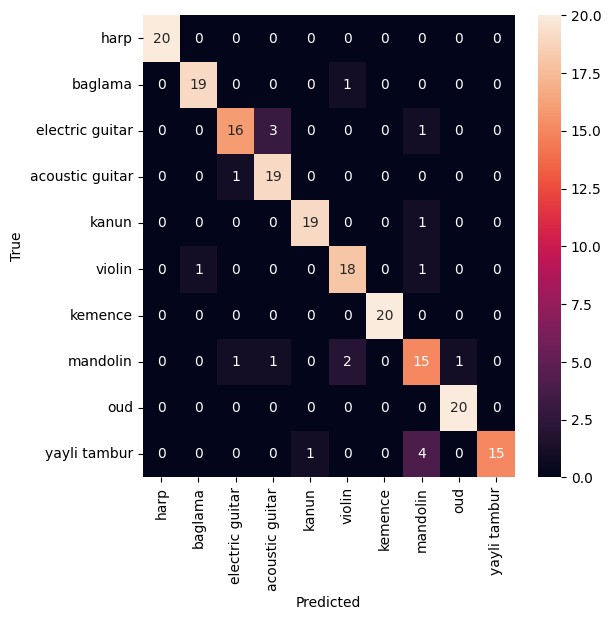

In [70]:
# generate confusion matrix
cm = confusion_matrix(true_label, pred_label)

# get labels from dictionary
label_keys = sorted(label_values.keys())  
label_list = [label_values[key] for key in label_keys]

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

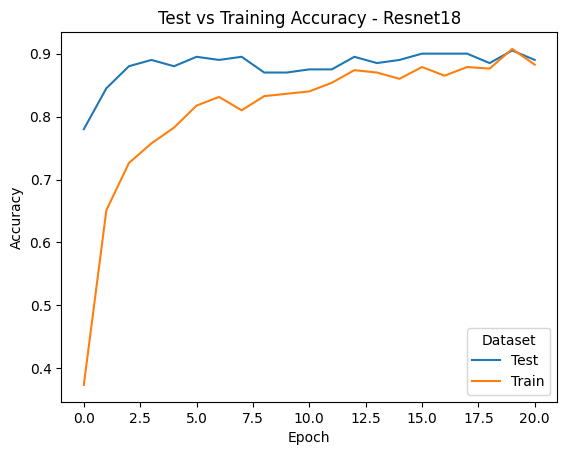

In [71]:
# plot to show the test and training accuracy over time
longform_results = pd.melt(training_results, id_vars=['epoch'], value_vars=['test_acc', 'train_acc'], var_name='Dataset', value_name='accuracy')

label_map = {'test_acc': 'Test', 'train_acc': 'Train'}
longform_results['Dataset'] = longform_results['Dataset'].replace(label_map)

# sns.lineplot(data=training_results, x='epoch', y='loss')
sns.lineplot(data=longform_results, x='epoch', y='accuracy', hue='Dataset')

plt.title('Test vs Training Accuracy - Resnet18')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

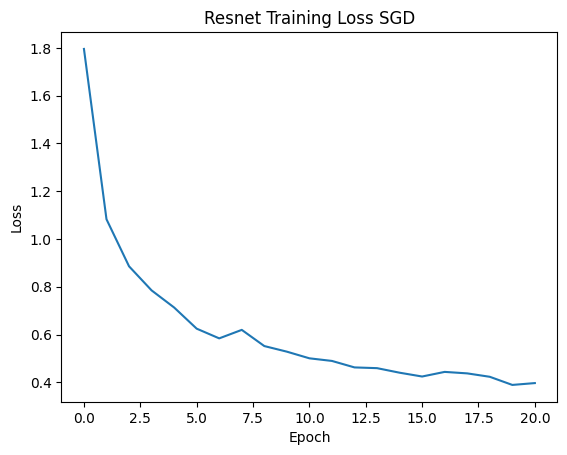

In [72]:
# plot to show the test and training accuracy over time
longform_results = pd.melt(training_results, id_vars=['epoch'], value_vars=['test_acc', 'train_acc'], var_name='Dataset', value_name='accuracy')

label_map = {'test_acc': 'Test', 'train_acc': 'Train'}
longform_results['Dataset'] = longform_results['Dataset'].replace(label_map)

sns.lineplot(data=training_results, x='epoch', y='loss')

plt.title('Resnet Training Loss SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Testing the Fine Tuned Model on Unfamiliar Images

In [73]:
# function to download image from URL
def download_image(url):
    headers = {'User-Agent': 'DanLucas (https://github.com/DanLucas1; dan.r.lucas@gmail.com)'}
    
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
    else:
        print(f"Error: Unable to download the image. HTTP status code: {response.status_code}")
    return image

def local_image(path):
    image = Image.open(path)
    return image

# transform to convert PIL image to tensor matching our huggingface data
PIL_transform = v2.Compose([
    v2.ToTensor(), # converts the image to a 0-1 PyTorch tensor
    v2.Lambda(lambda x: x * 255), # scale up to 255, now our PIL image is equivalent to one of the huggingface images
    # copy steps from our main transform function 
    v2.RandomResizedCrop(size=(224, 224), antialias=True), # resize for model requirements
    v2.RandomHorizontalFlip(p=0.5),
    scale_tensor, # converts to [0, 1] float dtype
    v2.Lambda(lambda x: torch.clamp(x, 0, 1)),  # clamp max values to 1 before normalization
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # required normalization for resnet
])

def process_image(image):
    return PIL_transform(image).to(device)

# function to download, transform, and classify the image
def classify_image(image_url):

    if 'http' in image_url:
        # download image
        image_pil = download_image(image_url)
    else:
        image_pil = local_image(image_url)
        
    # convert to PyTorch tensor
    image_tensor = process_image(image_pil).unsqueeze(0).to(device)

    # call the model to classify the image 
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)
    print('Prediction:', label_values[predicted.item()])
    # show the image and prediction
    image_pil = image_pil.resize((max(1, int(image_pil.size[0] * 300 / image_pil.size[1])), 300))
    image_pil.show()
    print('\n')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [74]:
# URLs of images to test
wikipedia_images =  {
    'Harp' : 'https://upload.wikimedia.org/wikipedia/commons/e/ef/Harpo_Marx_playing_the_harp.jpeg',
    'Bağlama' : 'https://upload.wikimedia.org/wikipedia/commons/0/05/Baglama_turc_manche_long.jpg',
    'Electric Guitar' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Gibson_Les_Paul_54_Custom.jpg/320px-Gibson_Les_Paul_54_Custom.jpg',
    'Acoustic Guitar' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Gibson_SJ200.jpg/800px-Gibson_SJ200.jpg',
    'Qanun' : 'https://upload.wikimedia.org/wikipedia/commons/1/1a/Q%C4%81n%C5%ABn_-_MET_89.4.330.jpg',
    'Violin' : 'https://upload.wikimedia.org/wikipedia/commons/9/9f/Stainer.jpg',
    'Kemenche' : 'https://upload.wikimedia.org/wikipedia/commons/e/ee/Kemenche0.jpg',
    'Mandolin' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Paris_Swing_Samois_Mandolin_MS-130-SN.jpg/800px-Paris_Swing_Samois_Mandolin_MS-130-SN.jpg',
    'Oud' : 'https://upload.wikimedia.org/wikipedia/commons/8/88/Oud2.jpg',
    'Yaylı tambur' : 'https://upload.wikimedia.org/wikipedia/commons/8/8a/Yayl%C4%B1Tambur_of_DrOzanYarman.jpg'
}

context_images = {
    'Fender Precision Bass' : '/workspace/pbass.jpg',
    'Fender Electric Guitar' : '/workspace/strat.jpg',
    'Jimi Hendrix' : 'https://miro.medium.com/v2/resize:fit:640/format:webp/0*f9ZzyN2ED0wHeVGj.jpg',
    'Martin Acoustic Guitar' : '/workspace/martin.jpg',
    'Johnny Cash' : 'https://www.nme.com/wp-content/uploads/2016/09/SnapGalleries180311.jpg'
}

#### Wikipedia examples for each instrument

Actual: Harp
Prediction: harp


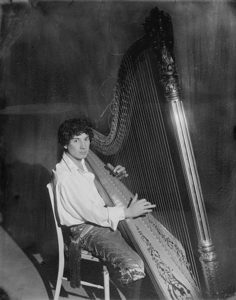



Actual: Bağlama
Prediction: baglama


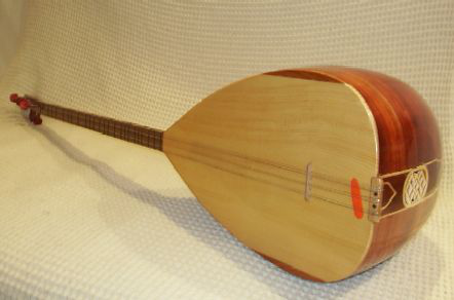



Actual: Electric Guitar
Prediction: electric guitar


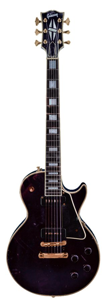



Actual: Acoustic Guitar
Prediction: electric guitar


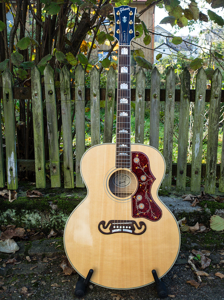



Actual: Qanun
Prediction: kanun


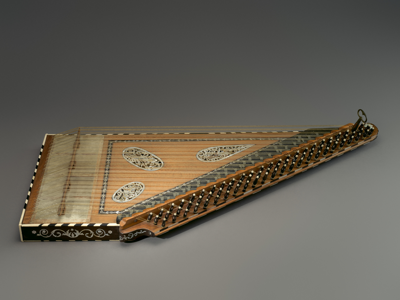



Actual: Violin
Prediction: violin


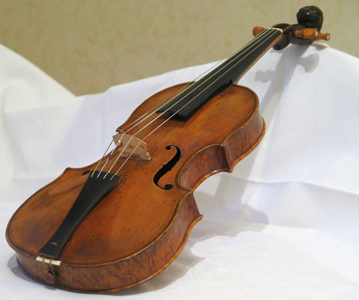



Actual: Kemenche
Prediction: kanun


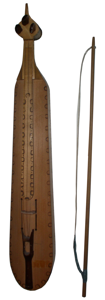



Actual: Mandolin
Prediction: mandolin


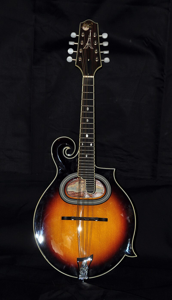



Actual: Oud
Prediction: oud


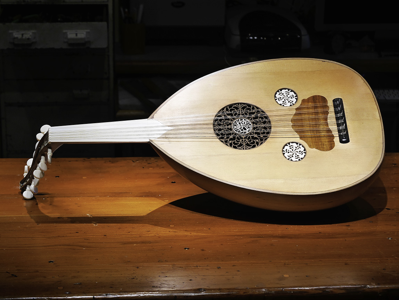



Actual: Yaylı tambur
Prediction: yayli tambur


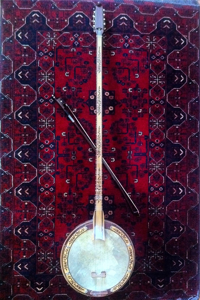

In [76]:
# Loop through images
for img in wikipedia_images:
    print('Actual:', img)
    classify_image(wikipedia_images[img])

#### Mixed context instrument examples

Fender Precision Bass
Prediction: electric guitar


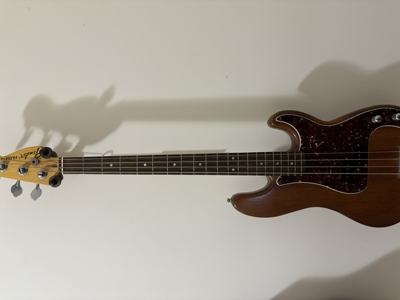



Fender Electric Guitar
Prediction: electric guitar


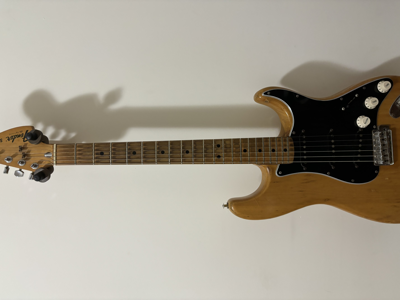



Jimi Hendrix
Prediction: kanun


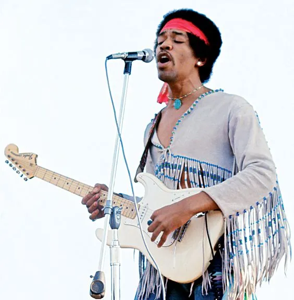



Martin Acoustic Guitar
Prediction: acoustic guitar


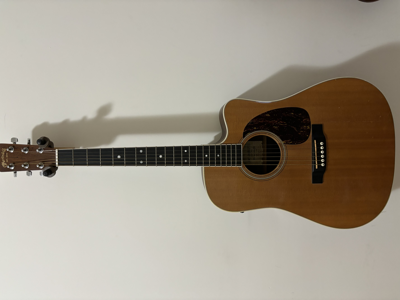



Johnny Cash
Prediction: mandolin


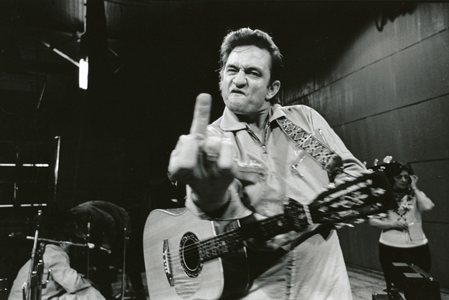

In [77]:
# Loop through images
for img in context_images:
    print(img)
    classify_image(context_images[img])